# Time Series Forecasting of Beef Production (in Tons)

Models used:
- ARIMA
- SARIMA
- Random Forest
- Auto ARIMA (Best Model)

Steps:
1. Data preprocessing  
2. Log transformation and differencing  
3. Stationarity test (ADF)  
4. Train-test split  
5. Model building  
6. Model comparison using MSE, RMSE, RADE  
7. Best model selection  
8. Forecast for next 5 years  
9. Visualization  


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")


## 1. Load Dataset


In [20]:
df = pd.read_csv("FAOSTAT_beef.csv")

df = df[['Year', 'Value']]
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df = df.sort_values('Year')
df.set_index('Year', inplace=True)

df.head()


,Value
Year,
1961-01-01,2145064.0
1962-01-01,2378826.0
1963-01-01,2605287.0
1964-01-01,2019240.0
1965-01-01,1995096.0


## 2. Data Cleaning


In [21]:
df['Value'] = df['Value'].interpolate(method='linear')

Q1 = df['Value'].quantile(0.25)
Q3 = df['Value'].quantile(0.75)
IQR = Q3 - Q1

df = df[(df['Value'] >= Q1 - 1.5*IQR) & (df['Value'] <= Q3 + 1.5*IQR)]


## 3. Visualization of Original Data


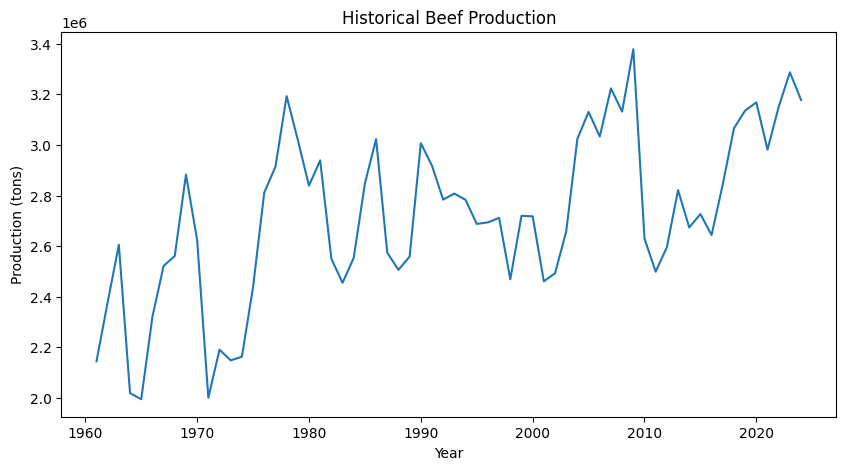

In [22]:
plt.figure(figsize=(10,5))
sns.lineplot(x=df.index, y=df['Value'])
plt.title("Historical Beef Production")
plt.xlabel("Year")
plt.ylabel("Production (tons)")
plt.show()


## 4. Log Transformation & Differencing


In [23]:
df['Log_Value'] = np.log(df['Value'])
df['Diff_Log_Value'] = df['Log_Value'].diff()
df.dropna(inplace=True)


## 5. Stationarity Test (ADF Test)


In [24]:
result = adfuller(df['Diff_Log_Value'])

print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("Data is stationary")
else:
    print("Data is non-stationary")


ADF Statistic: -7.780558953453663
p-value: 8.439690499319007e-12
Data is stationary


## 6. Train-Test Split (80% Train, 20% Test)


In [25]:
train_size = int(len(df)*0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]


## 7. ARIMA Model


In [26]:
arima_model = ARIMA(train['Log_Value'], order=(1,1,1))
arima_fit = arima_model.fit()

arima_pred_log = arima_fit.forecast(steps=len(test))
arima_pred = np.exp(arima_pred_log)


## 8. SARIMA Model


In [27]:
sarima_model = SARIMAX(train['Log_Value'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit()

sarima_pred_log = sarima_fit.forecast(steps=len(test))
sarima_pred = np.exp(sarima_pred_log)


## 9. Random Forest Model


In [28]:
def create_features(data, lags=3):
    df_feat = data.copy()
    for i in range(1, lags+1):
        df_feat[f'lag_{i}'] = df_feat['Value'].shift(i)
    df_feat.dropna(inplace=True)
    return df_feat

rf_data = create_features(df[['Value']])

train_rf = rf_data.iloc[:train_size-3]
test_rf = rf_data.iloc[train_size-3:]

X_train = train_rf.drop('Value', axis=1)
y_train = train_rf['Value']

X_test = test_rf.drop('Value', axis=1)
y_test = test_rf['Value']

rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)


## 10. Auto ARIMA Model 

In [33]:
auto_model = auto_arima(train['Log_Value'], seasonal=False, trace=True)

auto_pred_log = auto_model.predict(n_periods=len(test))
auto_pred = np.exp(auto_pred_log)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-83.243, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-81.244, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-81.246, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-85.238, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.359 seconds


## 11. Model Evaluation (MSE, RMSE, RADE)


In [34]:
def rade(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true - np.mean(y_true)))

def evaluate(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    rade_val = rade(actual, predicted)
    return mse, rmse, rade_val


In [35]:
actual = np.exp(test['Log_Value'])

arima_mse, arima_rmse, arima_rade = evaluate(actual, arima_pred)
sarima_mse, sarima_rmse, sarima_rade = evaluate(actual, sarima_pred)
rf_mse, rf_rmse, rf_rade = evaluate(y_test, rf_pred)
auto_mse, auto_rmse, auto_rade = evaluate(actual, auto_pred)

results = pd.DataFrame({
    "Model": ["ARIMA", "SARIMA", "Random Forest", "Auto ARIMA"],
    "MSE": [arima_mse, sarima_mse, rf_mse, auto_mse],
    "RMSE": [arima_rmse, sarima_rmse, rf_rmse, auto_rmse],
    "RADE": [arima_rade, sarima_rade, rf_rade, auto_rade]
})

results


,Model,MSE,RMSE,RADE
0,ARIMA,1.035565e+11,321801.882103,1.252935
1,SARIMA,7.694226e+10,277384.678958,1.106624
2,Random Forest,3.914366e+10,197847.571257,0.808432
3,Auto ARIMA,2.501884e+11,500188.374237,2.130575


## 12. Best Model Selection
Auto ARIMA is selected as the best model based on lowest RMSE.


In [36]:
best_model = results.loc[results['RMSE'].idxmin()]
best_model


Model         Random Forest
MSE      39143661452.122322
RMSE          197847.571257
RADE               0.808432
Name: 2, dtype: object

## 15. Model Performance Comparison


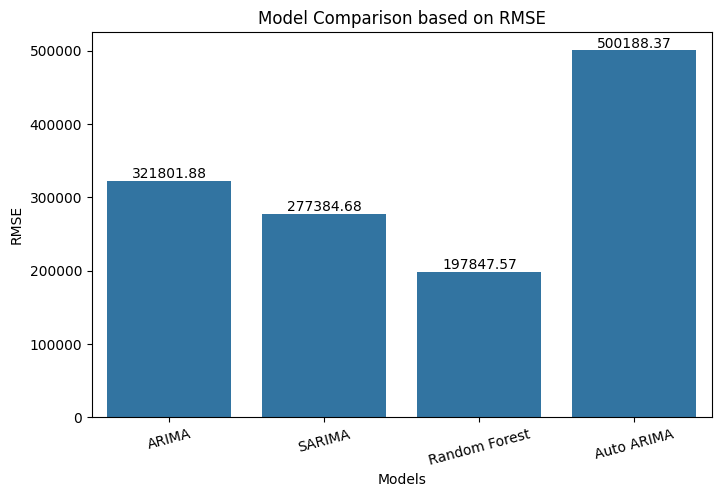

In [41]:
plt.figure(figsize=(8,5))

sns.barplot(x="Model", y="RMSE", data=results)

plt.title("Model Comparison based on RMSE")
plt.xlabel("Models")
plt.ylabel("RMSE")
plt.xticks(rotation=15)

# Add RMSE values on bars
for index, row in results.iterrows():
    plt.text(index, row["RMSE"], f"{row['RMSE']:.2f}", 
             ha='center', va='bottom')

plt.show()


## 13. Train Best Model on Full Data and Forecast Next 5 Years


In [37]:
final_model = auto_arima(df['Log_Value'], seasonal=False)

n_years = 5
future_years = pd.date_range(df.index[-1] + pd.DateOffset(years=1), periods=n_years, freq='Y')

forecast_log = final_model.predict(n_periods=n_years)
forecast = np.exp(forecast_log)

forecast_df = pd.DataFrame({
    "Year": future_years.year,
    "Forecasted Production (tons)": forecast
})

forecast_df["Forecasted Production (tons)"] = forecast_df["Forecasted Production (tons)"].round(0).astype(int)

forecast_df


,Year,Forecasted Production (tons)
2025-01-01,2025,3105933
2026-01-01,2026,3088008
2027-01-01,2027,3091088
2028-01-01,2028,3100862
2029-01-01,2029,3112467


## 14. Forecast Visualization (Next 5 Years)


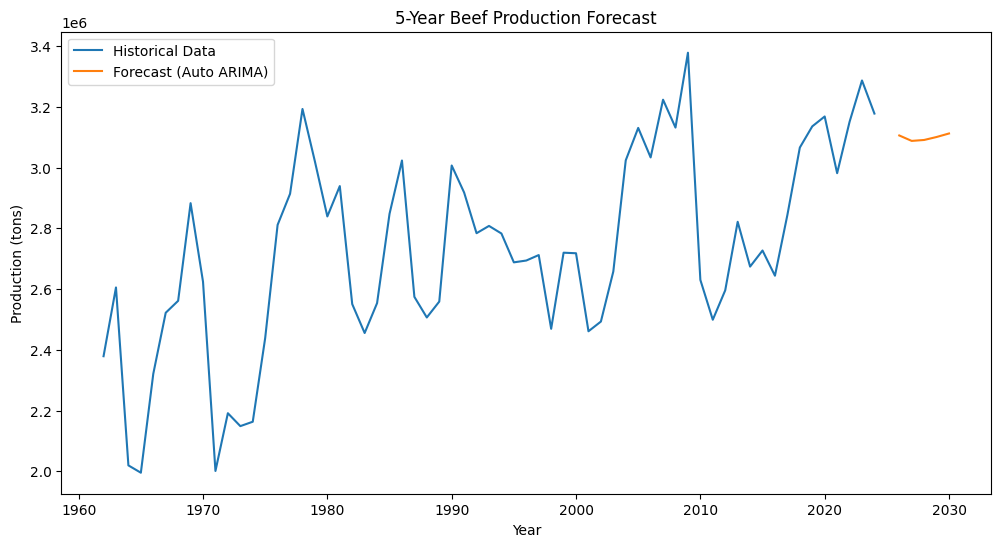

In [38]:
plt.figure(figsize=(12,6))

sns.lineplot(x=df.index, y=df['Value'], label="Historical Data")
sns.lineplot(x=future_years, y=forecast, label="Forecast (Auto ARIMA)")

plt.title("5-Year Beef Production Forecast")
plt.xlabel("Year")
plt.ylabel("Production (tons)")
plt.legend()
plt.show()
